# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

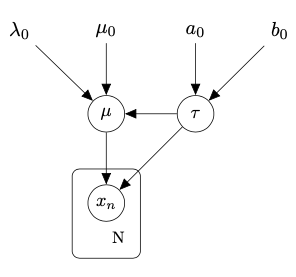

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [1]:
import numpy as np
def generate_data(mu, tau, N):
  '''
    Generate Gaussian distributed datasets of size N with 
    mean mu and precision tau
  '''
  sigma = 1/np.sqrt(tau)
  X = np.random.normal(mu, sigma, N)
  return X


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



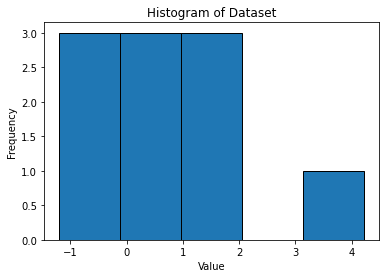

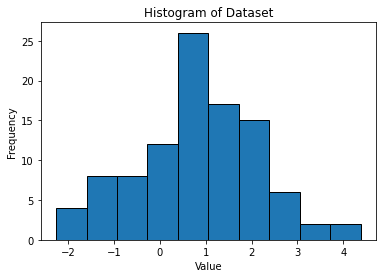

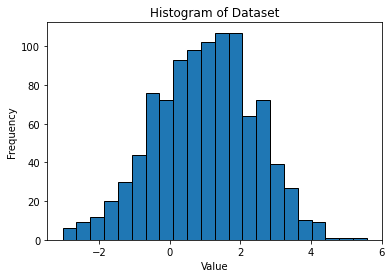

In [2]:
import matplotlib.pyplot as plt

mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
def PlotHistogram(X):
  plt.hist(X, bins='auto', edgecolor='black')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('Histogram of Dataset')

  plt.show()

PlotHistogram(dataset_1)
PlotHistogram(dataset_2)
PlotHistogram(dataset_3)


### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [3]:
def ML_est(data):
  mu_ml = np.mean(data)
  N = len(data)
  sum = 0
  for x in data:
    sum += (x-mu)**2
  sample_variance = sum / N
  tau_ml = 1/sample_variance

  return mu_ml, tau_ml

print(ML_est(dataset_3)) 
#mu_ml is mean of data
#tau_ml is reciprocal of sample variance 

(0.9846324809055897, 0.5035608150317067)


### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [4]:
# prior parameters
mu_0 = float(1.5)
lambda_0 = float(1)
a_0 = float(1)
b_0 = float(2)

Continue with a helper function that computes ELBO:


In [13]:
# from scipy.stats import gamma, norm
import math
from scipy.special import digamma #, gamma
from math import gamma, log
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  E_ln_tau = digamma(a_N) - np.log(b_N)
  E_tau = a_N / b_N
  E_mu = mu_N
  E_mu2 = mu_N**2 + 1 / lambda_N
  N = len(D)

  term1 = E_ln_tau * (N/2 + 1/2 + a_0 - 1)
  sum = 0
  for x in D:
    sum += x**2 - 2*x*E_mu + E_mu2
  
  term2 = -E_tau * (0.5 * sum + 0.5 * (E_mu2 - 2*mu_0*E_mu * mu_0**2) + b_0)
  
  term3 = -N/2 * np.log(2*math.pi) + a_0 * np.log(b_0) - log(gamma(a_0)) - 0.5 * np.log(lambda_N) + 0.5

  term4 = a_N - np.log(b_N) + np.log(gamma(a_N)) + (1 - a_N) * digamma(a_N)

  elbo = term1 + term2 + term3 + term4
  
  return elbo


Now, implement the CAVI algorithm:

In [6]:
import numpy as np
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  N_iterations = 1000
  initial_guess_exp_tau = a_0 / b_0
  elbos = np.zeros((N_iterations,1))
  N = len(D)
  x_mean = np.mean(D)
  a_N = a_0
  b_N = b_0

  # CAVI iterations ...
  # save ELBO for each iteration, plot them afterwards to show convergence
  counter = -1
  for i in range(int(N_iterations/2)):
    counter += 1
    E_tau = a_N / b_N
    mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
    lambda_N = (lambda_0 + N) / E_tau

    elbos[counter] = compute_elbo(D,a_0,b_0,mu_0,lambda_0,a_N,b_N,mu_N,lambda_N)

    a_N = a_0 + N / 2
    sum = 0
    for x in D:
      sum += x**2 - 2*x*mu_N + mu_N**2 + 1/lambda_N
    b_N = b_0 + 0.5 * sum + (lambda_0 / 2) * (mu_N**2 + 1/lambda_N - 2*mu_0*mu_N + mu_0**2)

    counter += 1
    elbos[counter] = compute_elbo(D,a_0,b_0,mu_0,lambda_0,a_N,b_N,mu_N,lambda_N)

  return a_N, b_N, mu_N, lambda_N, elbos

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [7]:
from scipy.special import gamma
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0, mu, tau):
  N = len(D)
  beta = b_0 + 0.5 * np.sum(D**2) + 0.5 * lambda_0 * mu_0**2 - (lambda_0 * mu_0 + np.sum(D))**2 / (2 * (N + lambda_0))
  alpha = a_0 + N / 2
  l = N + lambda_0
  m = ((lambda_0 * mu_0) + np.sum(D)) / (N + lambda_0)
  
  p = (beta**alpha * np.sqrt(l)) / (gamma(alpha) * np.sqrt(2*np.pi)) * tau**(alpha - 1) * np.exp(-beta*tau) * np.exp(-l*tau*(mu - m)**2 / 2)

  return p

In [8]:
from scipy.stats import gamma, norm
def computeCAVI(a_N, b_N, mu_N, lambda_N, mu, tau):
  #scipy.gamma() * scipy.normal()
  q = gamma.pdf(tau, a_N, scale=b_N) * norm.pdf(mu, mu_N, 1/np.sqrt(lambda_N))
  
  return q

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



[[-200.13072077]
 [-172.27158933]
 [-172.22302337]
 [-172.22390902]
 [-172.22405139]
 [-172.22404851]
 [-172.22404804]
 [-172.22404805]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.22404806]
 [-172.2240480

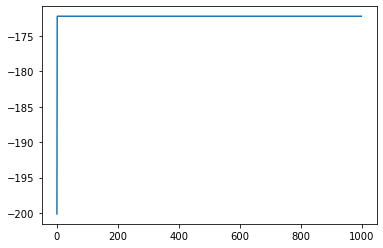

In [14]:
import matplotlib.pyplot as plt


# Example flow for dataset_2:
  ##  plot elbos, show convergence
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot
  ##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##Contour plots
mu_ml, tau_ml = ML_est(dataset_2)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
plt.plot(elbos)
print(elbos)
  ##create tau and mu vectors (linspace from -1 to 1 - 100 points?)
  



